# cosmoprimo examples

## Cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cosmoprimo import *

In [2]:
# Start with some vanilla cosmology
cosmo = Cosmology()
# Planck2018 TT, TE, EE, lowE, lensing and BAO data
cosmo_planck = fiducial.Planck2018FullFlatLCDM()
# Custom cosmology
cosmo_custom = Cosmology(omega_cdm=0.2, sigma8=0.7)
print('You can provide the following parameters (including conflicts):',
      cosmo.get_default_parameters(include_conflicts=True))

You can provide the following parameters (including conflicts): {'h': 0.7, 'Omega_cdm': 0.25, 'Omega_b': 0.05, 'Omega_k': 0.0, 'sigma8': 0.8, 'k_pivot': 0.05, 'n_s': 0.96, 'alpha_s': 0.0, 'r': 0.0, 'T_cmb': 2.7255, 'm_ncdm': None, 'neutrino_hierarchy': None, 'T_ncdm_over_cmb': 0.71611, 'N_eff': 3.044, 'tau_reio': 0.06, 'reionization_width': 0.5, 'A_L': 1.0, 'w0_fld': -1.0, 'wa_fld': 0.0, 'H0': 0.7, 'omega_cdm': 0.25, 'Omega0_cdm': 0.25, 'Omega_c': 0.25, 'omega_c': 0.25, 'omega_b': 0.05, 'Omega0_b': 0.05, 'A_s': 0.8, 'ln10^{10}A_s': 0.8, 'Omega_g': 2.7255, 'omega_g': 2.7255, 'Omega0_g': 2.7255, 'Omega_ncdm': None, 'omega_ncdm': None, 'Omega0_ncdm': None, 'N_ur': 3.044, 'Omega_ur': 3.044, 'omega_ur': 3.044, 'Omega0_ur': 3.044, 'z_reio': 0.06, 'non_linear': '', 'modes': 's', 'lensing': False, 'z_pk': None, 'kmax_pk': 10.0, 'ellmax_cl': 2500}


In [3]:
# Input and easily derived parameters can be accessed through indexing
print('h', cosmo['h'], cosmo_custom['h'])
print('Omega_cdm', cosmo['Omega_cdm'], cosmo_custom['Omega_cdm'])

h 0.7 0.7
Omega_cdm 0.25 0.4081632653061225


## Fiducial cosmologies

In [4]:
# Some fiducial cosmologies are provided, e.g.:
from cosmoprimo.fiducial import Planck2018FullFlatLCDM, AbacusSummitBase, DESI, TabulatedDESI
cosmo = DESI()
cosmo_tabulated = TabulatedDESI() # tabulated z-> distance relation, does not require any engine
z = np.linspace(0., 10., 1000)
assert np.allclose(cosmo_tabulated.comoving_radial_distance(z), cosmo.comoving_radial_distance(z), rtol=1e-5)

## Engines & sections

In [5]:
# Cosmological calculation is performed by engines, by section 
# (Background, Thermodynamics, Primordial, Perturbations, Transfer, Harmonic, Fourier)
# engines can be set once for all sections as:
cosmo = Cosmology(engine='class')
# or:
cosmo.set_engine('camb')
# or you can pass an engine instance directly
cosmo.set_engine(engine=cosmo.engine) # CLASS engine was attached to cosmo with the previous call
# then you don't need to specify it when calling specific section, e.g.
ba = cosmo.get_background()
# or:
ba = Background(cosmo)
# you can temporarily switch to another engine with:
ba = cosmo.get_background(engine='camb', set_engine=False)
# or:
ba = Background(cosmo,engine='camb', set_engine=False)
assert cosmo.engine is not ba.engine # class engine

## Shortcuts

In [6]:
# If you are lazy, and you want to access directly a quantity which will be in only one section, e.g.:
cosmo = Cosmology(engine='class')
z = 0.2
d = cosmo.comoving_radial_distance(z)
# is equivalent to cosmo.get_background().comoving_radial_distance(z)
assert np.all(d == cosmo.get_background().comoving_radial_distance(z))
# However, you will get into troubles if some attributes/methods 
# of e.g. section "Fourier" are the same as section "Fourier" (e.g. "table")
assert 'table' in dir(cosmo.get_transfer())
assert 'table' in dir(cosmo.get_fourier())
# Note that available attributes/methods are accessible through dir():
print('Attributes/methods available with class engine are {}'.format(dir(cosmo)))
# and their doc is given by .__doc__, e.g.
print(cosmo.comoving_radial_distance.__doc__)
# Available attributes/methods can be different with a different engine, e.g.
assert set(dir(cosmo)) != set(dir(Cosmology(engine='eisenstein_hu')))

Attributes/methods available with class engine are ['A_s', 'H0', 'N_eff', 'N_ncdm', 'N_ur', 'Omega0_Lambda', 'Omega0_b', 'Omega0_cdm', 'Omega0_dcdm', 'Omega0_de', 'Omega0_fld', 'Omega0_g', 'Omega0_k', 'Omega0_m', 'Omega0_ncdm', 'Omega0_ncdm_tot', 'Omega0_pncdm', 'Omega0_pncdm_tot', 'Omega0_r', 'Omega0_ur', 'Omega_Lambda', 'Omega_b', 'Omega_cdm', 'Omega_dcdm', 'Omega_de', 'Omega_fld', 'Omega_g', 'Omega_k', 'Omega_m', 'Omega_ncdm', 'Omega_ncdm_tot', 'Omega_pncdm', 'Omega_pncdm_tot', 'Omega_r', 'Omega_ur', 'T0_cmb', 'T0_ncdm', 'T_cmb', 'T_ncdm', '_RH0_', '__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chec

## Save/load

In [7]:
# You can save/load any cosmology instance this way:
import os
import tempfile

with tempfile.TemporaryDirectory() as tmp_dir: # in a temporary file to avoid messing up our directory
    fn = os.path.join(tmp_dir, 'cosmo.npy')
    cosmo.save(fn)
    cosmo2 = Cosmology.load(fn)

for param in cosmo.params:
    if isinstance(cosmo[param], np.ndarray):
        assert np.all(cosmo2[param] == cosmo[param])
    else:
        assert cosmo2[param] == cosmo[param]
# Note however that this will not save any calculated quantity

## Background

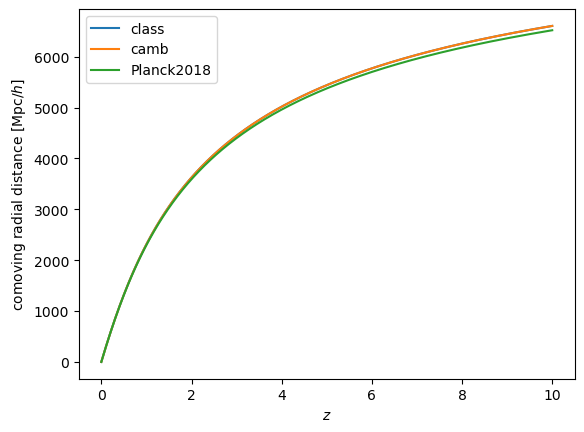

In [8]:
# You can choose an engine ('class','camb','eisenstein_hu' for approximations) for the calculation
# Do ba = Background(cosmo,engine='class') or:
ba = cosmo.get_background(engine='class') # e.g. precision parameters can be passed as other arguments
ba_camb = Background(cosmo, engine='camb') # alternative way of getting background
z = np.linspace(0.,10.,1000)
plt.plot(z, ba.comoving_radial_distance(z), label='class')
plt.plot(z, ba_camb.comoving_radial_distance(z), label='camb')
plt.plot(z, cosmo_planck.get_background(engine='class').comoving_radial_distance(z), label='Planck2018')
# Redoing cosmo_planck.get_background(engine='class') will not recompute the background, it's saved one for all!
# (cosmology instance is immutable)
plt.xlabel('$z$')
plt.ylabel('comoving radial distance [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

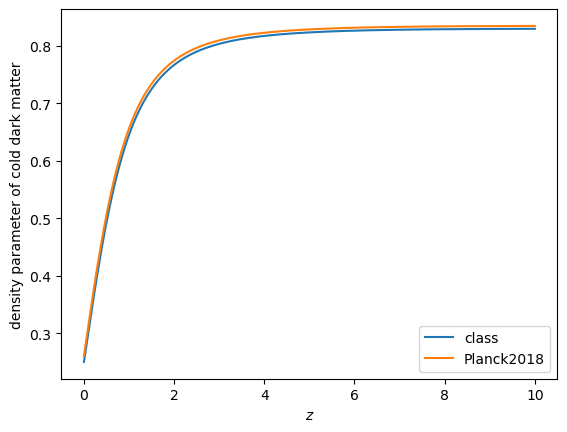

In [9]:
# Many quantities are available: densities, distances;
# Look at the doc (for class, look at http://github.com/adematti/pyclass)
plt.plot(z, ba.Omega_cdm(z), label='class')
plt.plot(z, cosmo_planck.get_background(engine='class').Omega_cdm(z), label='Planck2018')
plt.xlabel('$z$')
plt.ylabel('density parameter of cold dark matter')
plt.legend()
plt.show()

## You can also access thermodynamics quantities (``cosmo.get_thermodynamics()``), primordial quantities, etc. Let's move to...

## Perturbations

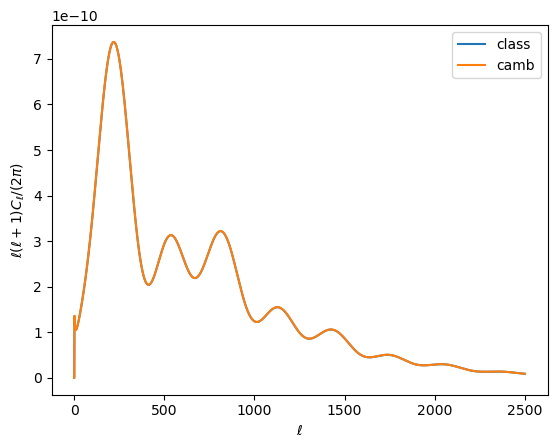

In [10]:
hr = Harmonic(cosmo,engine='class')
cls = hr.unlensed_cl()
ells_factor = (cls['ell'] + 1) * cls['ell'] / (2 * np.pi)
plt.plot(cls['ell'],ells_factor*cls['tt'], label='class')
hr = cosmo.get_harmonic(engine='camb') # second initialisation style
cls = hr.unlensed_cl() # same number of cells are output than in CLASS
plt.plot(cls['ell'],ells_factor*cls['tt'], label='camb')
plt.xlabel('$\ell$')
plt.ylabel('$\ell(\ell+1)C_{\ell}/(2\pi)$')
plt.legend()
plt.show()
# If you want lensed_cl(), you must set lensing=True as part of the Cosmology arguments

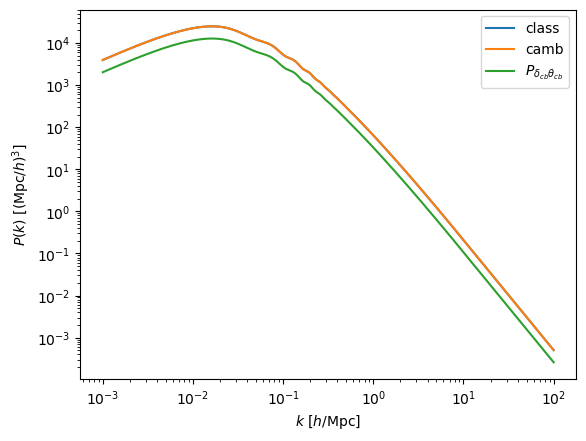

In [11]:
fo = Fourier(cosmo, engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-3,2,1000)
z = 0
plt.loglog(k, pk(k,z=z), label='class')
fo_camb = cosmo.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k, pk(k,z=z), label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('delta_cb','theta_cb'))(k,z=z), label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

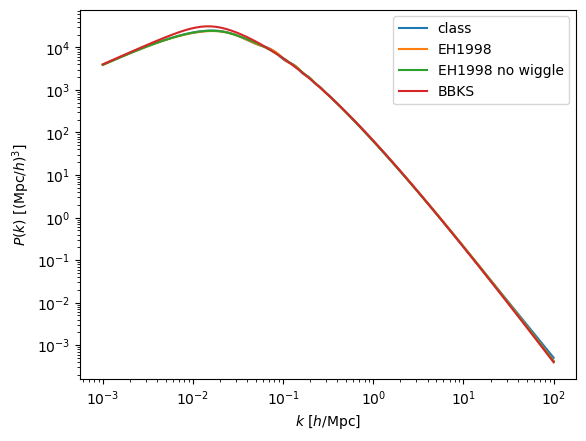

In [12]:
# Fast approximations
pk = fo.pk_interpolator()
plt.loglog(k, pk(k,z=z), label='class')
plt.loglog(k, Fourier(cosmo,'eisenstein_hu').pk_interpolator()(k,z=z), label='EH1998')
plt.loglog(k, Fourier(cosmo,'eisenstein_hu_nowiggle').pk_interpolator()(k,z=z), label='EH1998 no wiggle')
plt.loglog(k, Fourier(cosmo,'bbks').pk_interpolator()(k,z=z), label='BBKS')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

## Note about $f\sigma_{8}$: better computed as the r.m.s. of velocity perturbations

In [13]:
fo = Fourier(cosmo,engine='class')
print('fsigma8 is',fo.sigma8_z(z=0, of='theta_cb'))

fsigma8 is 0.41020946472458897


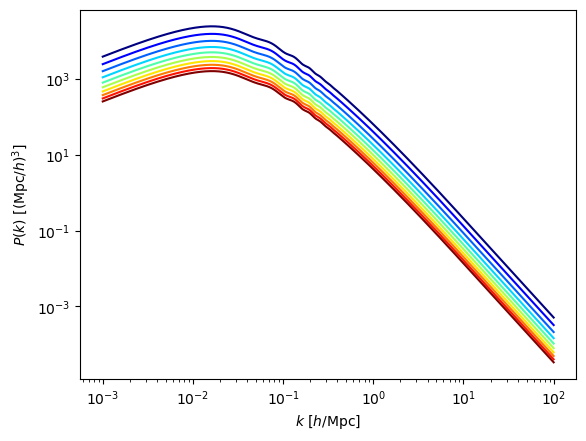

In [14]:
# As a function of z
k = np.logspace(-3, 2, 1000)
z = np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
for zz,color in zip(z, colors):
    plt.loglog(k, pk(k, z=zz), color=color)
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()

## Interpolators: easy handling of $P(k)$/$\xi(s)$

In [15]:
# 2D (k,z) interpolator (vectorized, of course)
pk = fo.pk_interpolator()
k, z = 0.1, 1.
print('2D power spectrum at k = {}, z = {} is {}'.format(k, z, pk(k,z)))
# cast to 1D z interpolator (tiny interpolation error)
pk1d = pk.to_1d(z=z)
print('1D power spectrum at k = {}, z = {} is {}'.format(k, z, pk1d(k)))
# interpolators can be built from callables, e.g.
pk1dc = PowerSpectrumInterpolator1D.from_callable(pk_callable=pk1d)
print('1D power spectrum from callable at k = {}, z = {} is {}'.format(k, z, pk1dc(k)))

2D power spectrum at k = 0.1, z = 1.0 is 1978.8576273540396
1D power spectrum at k = 0.1, z = 1.0 is 1978.8576273540436
1D power spectrum from callable at k = 0.1, z = 1.0 is 1978.8576273540436


In [16]:
# Get sigma_rz() (vectorised)
r,z = 2.,1.
print('quadpack integration sigmarz = {} v.s. FFTlog sigmarz = {}'.format(pk.sigma_rz(r,z,nk=None), pk.sigma_rz(r,z)))
# Estimate fsigma_rz()
print('quadpack integration fsigmarz = {} v.s. FFTlog fsigmarz = {}'.format(pk.growth_rate_rz(r,z,nk=None), pk.growth_rate_rz(r,z)))

quadpack integration sigmarz = 1.079326477177664 v.s. FFTlog sigmarz = 1.0793230778198046
quadpack integration fsigmarz = 0.8690220876142463 v.s. FFTlog fsigmarz = 0.8689118376687954


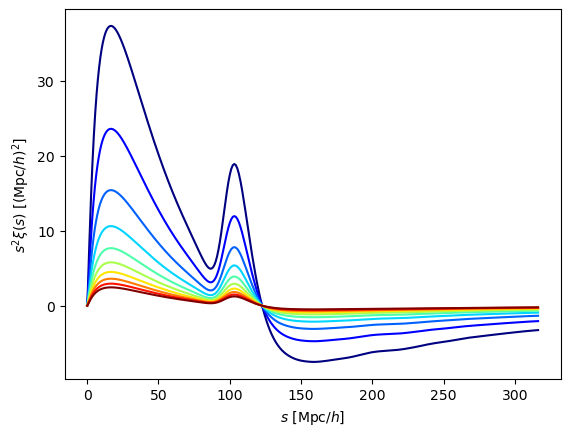

In [17]:
# FFTlog transform (vectorised) to xi...
xi = pk.to_xi()
s = np.logspace(-2., 2.5, 1000)
z = np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
for zz, color in zip(z, colors):
    plt.plot(s, s**2*xi(s,z=zz), color=color)
plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

## BAO filters

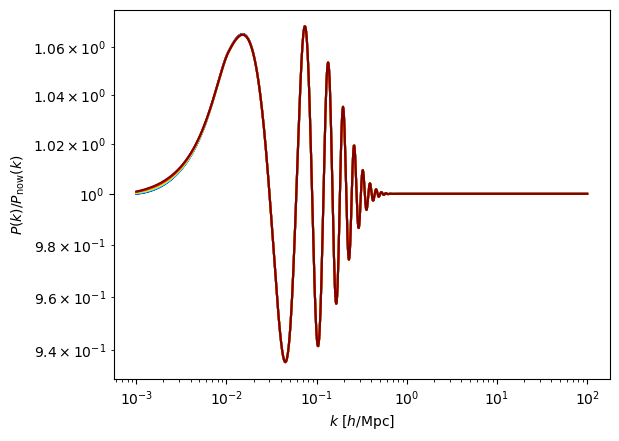

In [18]:
# Several engines are available for the power spectrum, but wallish2018 is the most accurate one
# Note one can also provide a 1D power spectrum interpolator
pknow = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()
k = np.logspace(-3, 2, 1000)
z = np.linspace(0., 4., 10)
colors = plt.cm.jet(np.linspace(0, 1, len(z)))
for zz, color in zip(z, colors):
    plt.loglog(k, pk(k, z=zz)/pknow(k, z=zz),color=color)
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)/P_{\mathrm{now}}(k)$')
plt.show()

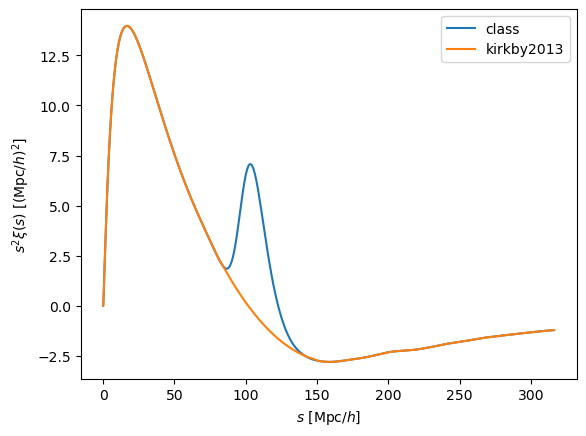

In [19]:
# For the correlation function, the Kirkby2013 approach
xinow = CorrelationFunctionBAOFilter(xi, engine='kirkby2013').smooth_xi_interpolator()
s = np.logspace(-2.,2.5,1000)
z = 1
plt.plot(s, s**2*xi(s,z=z), label='class')
plt.plot(s, s**2*xinow(s,z=z), label='kirkby2013')
plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()